In [1]:
import tensorflow as tf

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logging.getLogger("tensorflow").disabled = True

In [5]:
model = VGG16(weights="imagenet",
              include_top=False)

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [49]:
def deprocess_image(x):
    x -= tf.reduce_mean(x)
    x /= (tf.math.reduce_std(x) + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [95]:
def generate_filter_visualization(layer_name,filter_index,model,size=64):
    activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    step = 1.
    input_img = tf.convert_to_tensor(np.random.random((1,size,size,3)).astype("float32"))
    for i in range(40):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            preds = activation_model(input_img)
            loss = tf.reduce_mean(preds[0][:,:,filter_index])
        grads = tape.gradient(loss,input_img)
        input_img += grads * step
    return deprocess_image(input_img)

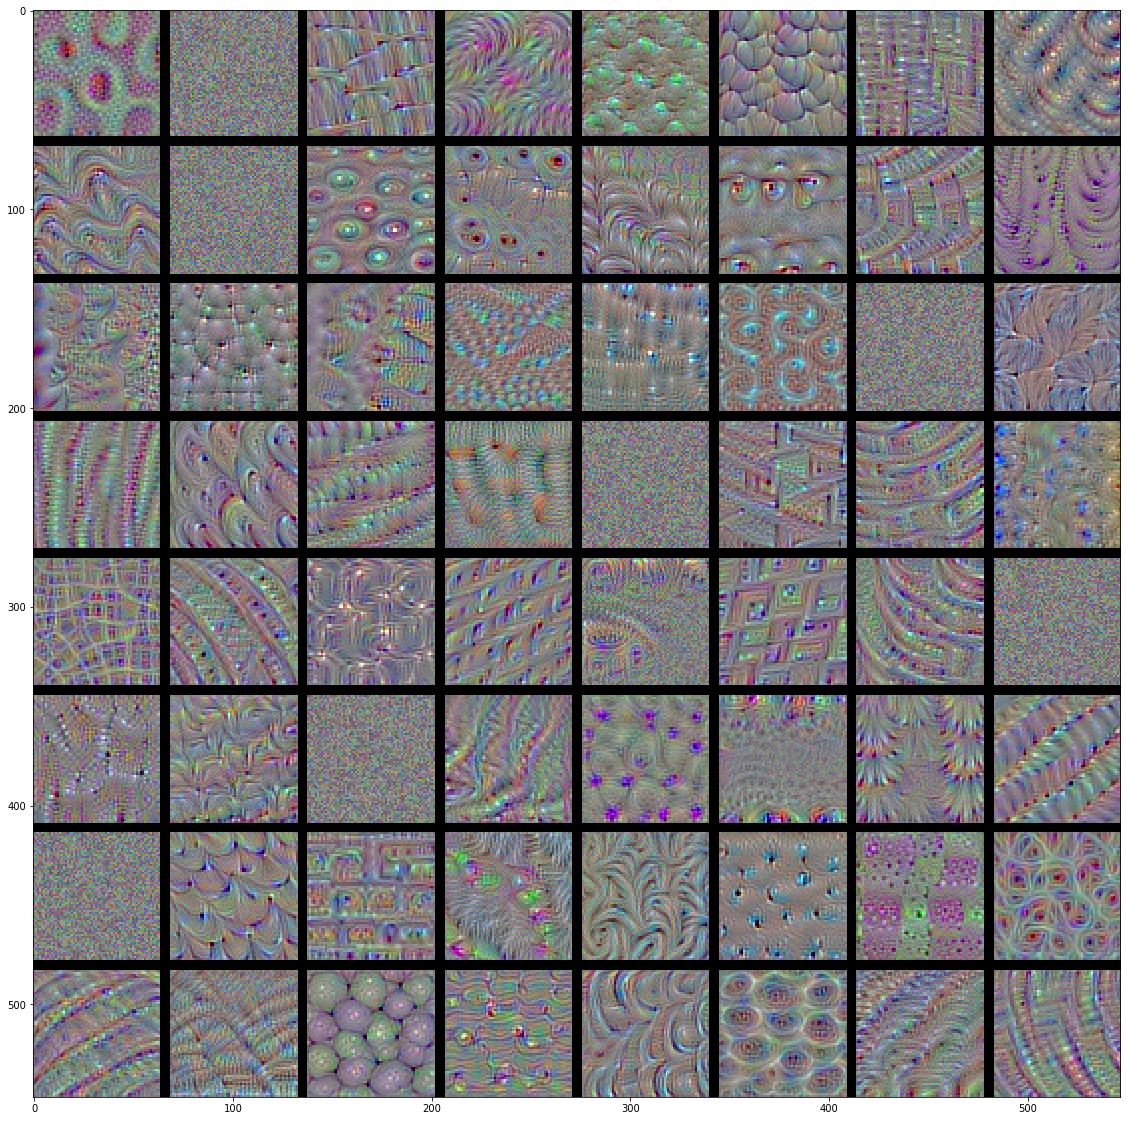

In [102]:
size = 64
margin = 5
layer_name = "block4_conv1"

results = np.zeros((8*size+7*margin,8*size+7*margin,3)).astype(np.uint8)

for i in range(8):
    for j in range(8):
        viz_img = generate_filter_visualization(layer_name,i+(j*8),model)

        v_start = i * size + i * margin
        v_end = v_start + size
        h_start = j * size + j * margin
        h_end = h_start + size
        results[v_start:v_end,h_start:h_end,:] = viz_img
plt.figure(figsize=(20,20))
plt.imshow(results)